In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

In [2]:
mypath = '/Users/jielaizhang/Desktop/waissya/WAISSYA_LCO/Target_C/V/'
outmoviename='mymovie.gif'

In [3]:
# Load in all of the fits images in the directory and sort it

image_list = glob.glob(mypath+'*e91.fits.fz')
image_list.sort()

In [4]:
#Make some useful lists of values to track/record

obstime = []
Bmag = []
Vmag = []
Bmag_e = []
Vmag_e = []
avg_offset = []

In [5]:
# Input the information for the calibration stars identified
# in the previous notebook for batch processing of all of the images

tar_ra    = 83.141298 # 83.14124
tar_dec   = -6.4465556 # -6.44638
tar_color = 'yellow'
ref_ra = [83.109976,  83.132544, 83.17554,   83.215047, 83.217818]
ref_dec = [-6.2953274,-6.3842993,-6.4845496,-6.4945602,-6.5106954]
ref_colors = ['white','white','white','white']
ref_mag   = [9.436,11.759,12.031,9.446,8.801]

In [6]:
def do_phot_get_mag(data,hdr,err,ra,dec):
    zpt_instrumental = 25.
    w = wcs.WCS(hdr)
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    positions = np.transpose((xcoords, ycoords))
    apertures = CircularAperture(positions, r=24.)
    phot = aperture_photometry(data, apertures, error=err)

    mag = list(-2.5*np.log10(phot['aperture_sum']) + zpt_instrumental)
    dmag = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,dmag

In [7]:
def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

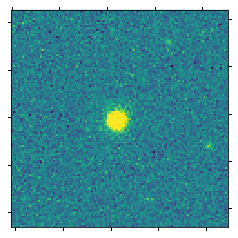

In [8]:
# Let's calculate the star's mag for *each* frame in the dataset

for frame in image_list:
    hdu = fits.open(frame)

    # Grab the actual science data based on above.
    sci_data = hdu[1]
    sci_hdr = sci_data.header
    time = sci_hdr['MJD-OBS']
    obstime.append(time)

    # Background estimation:
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data.data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data.data - bkg.background

    # Define an error image that will be used when calculating photometry
    effective_gain = 1.
    error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

    # Calculate instrumental mags for each of the reference stars
    cal_mag,cal_dmag = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

    # Calculate offsets and the standard deviation of the offset from each star.
    offsets = []
    for i in range(len(cal_mag)):
        offsets.append(ref_mag[i] - cal_mag[i])
    offset = np.mean(offsets)
    avg_offset.append(offset)
    doffset = np.std(offsets)
    
    # Do photometry on the variable target!!
    tar_mag,tar_dmag = do_phot_get_mag(sci_bkg,sci_hdr,error,tar_ra,tar_dec)
    
    cal_tar_mag = tar_mag[0]+offset
    cal_tar_dmag = np.sqrt(tar_dmag[0]**2.+doffset**2.)
    
    Bmag.append(cal_tar_mag)
    Bmag_e.append(cal_tar_dmag)
    
    # Make tiny cutouts of the variable star in each frame
    cutout_hdu = make_cutout(sci_bkg,sci_hdr,tar_ra,tar_dec)
    #cutout_hdu.writeto(frame+'_cutout.fits', overwrite=True)
    
    # Plot figures using these cutouts and output images
    interval = ZScaleInterval()
    vmin = interval.get_limits(cutout_hdu.data)[0]
    vmax = interval.get_limits(cutout_hdu.data)[1]

    plt.subplot(projection=wcs.WCS(cutout_hdu.header))
    plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.xlabel('R.A.')
    plt.ylabel('Declination')
    
    pngname = str(time).replace('.','')
    plt.savefig(mypath+pngname+'.png', overwrite=True)

In [9]:
print(len(obstime))
print(len(Bmag))
print(len(image_list))

25
25
25


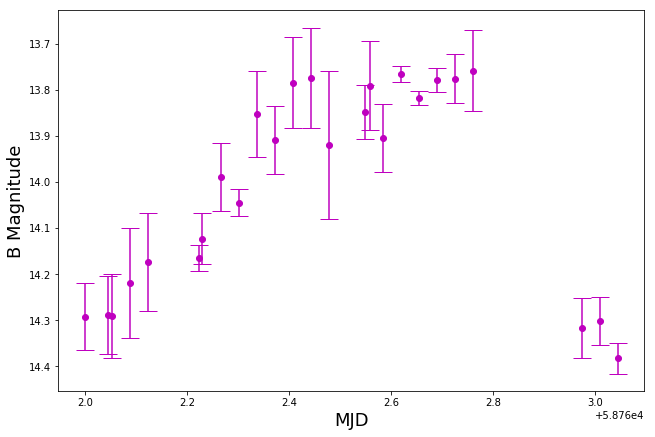

In [13]:
# # Make a rudimentary lightcurve

plt.figure(figsize=(10.5, 7))
plt.errorbar(obstime,Bmag,xerr=None,yerr=Bmag_e, fmt='mo', capsize=9.0)
plt.xlabel('MJD', fontsize=18)
plt.ylabel('B Magnitude', fontsize=18)
plt.gca().invert_yaxis()
plt.show()

In [11]:
# Here we are going to use the cutouts we made above to make
# an little movie of the variable star target changing brightness
# over time and loop it!

import imageio

cutout_list = glob.glob(mypath+'*.png')
cutout_list.sort()

cutout_frames = []
for file in cutout_list:
    cutout_frames.append(imageio.imread(file))
imageio.mimsave(mypath+'mymovie.gif', cutout_frames)

In [12]:
print(Bmag)
print(obstime)
print(Bmag_e)

[13.765438316172824, 13.817675431163583, 13.778446476822863, 13.776099636414683, 13.759027655472595, 14.29185339259901, 14.288655710415032, 14.291040501617793, 14.219052947642094, 14.173262953025468, 14.316840450598873, 14.301468080391965, 14.382640524945536, 13.78459292223291, 13.774162831799844, 13.920273343240504, 14.165238294500332, 14.12309540980244, 13.989998042497428, 13.85197946946412, 13.908715088952892, 14.045187805554074, 13.90409276484365, 13.848327343755432, 13.791110062323234]
[58762.6200075, 58762.6554484, 58762.6908188, 58762.7261979, 58762.7616765, 58762.0001943, 58762.0454038, 58762.0532284, 58762.0887156, 58762.1241327, 58762.9746017, 58763.0105724, 58763.0449853, 58762.4074354, 58762.4428839, 58762.4783329, 58762.2243492, 58762.2303189, 58762.2658236, 58762.336722, 58762.372081, 58762.3012234, 58762.5845573, 58762.5491357, 58762.5592223]
[0.017804359865600892, 0.015524300460789916, 0.02607212766138994, 0.05271542244777149, 0.08743331795765091, 0.07195236304753636, 0